In [1]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy

In [2]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


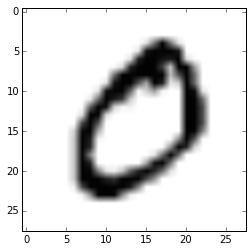

In [3]:
data_array = mnist.data
plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

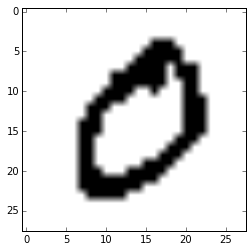

In [4]:
#Convert image to binary matrix
for img in data_array:
    img[img < 100] = 0
    img[img > 0] = 1

plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

In [5]:
class RBM(object):
    """
    Implementation of Restricted Boltzmann Machine for binary prediction
    
    Inputs:
    Data
    Number of hidden and visible states
    Learning rate, default set to 0.1
    
    Outputs:
    Weight matrix
    Epoch number and error
    """

    def __init__(self, data, num_visible, num_hidden, num_epochs, learning_rate=0.1):
        
        self.data = data
        self.num_data = data.shape[0]
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        # weight matrix first row and first column represent the bias
        self.weights = np.random.rand(self.num_visible, self.num_hidden) 
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
    
    def _sigmoid(self,x):
        return 1.0/(1.0+np.exp(-x))
    
    def _gen_prob(self,a,b):
        return self._sigmoid(np.dot(a,b))
    
    def _gen_assoc(self,a):
        probs = self._gen_prob(a,self.weights)
        return np.dot(a.T,probs)

    def CDk(self):
        max_epochs = self.num_epochs + 1
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        for epoch in xrange(0, max_epochs):
            up_probs = self._gen_prob(self.data,self.weights)
            up_associations = self._gen_assoc(self.data)
            up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)
            
            down_probs = self._gen_prob(up_states,self.weights.T)
            down_probs[:,0] = 1 
            down_associations = self._gen_assoc(down_probs)
            
            self.weights += self.learning_rate * \
                ((up_associations - down_associations)/self.num_data)
                
            error = np.sum((self.data - down_probs) ** 2)
            print("Epoch: ", epoch, ", Error: ", error)
            if epoch == self.num_epochs:
                return down_probs
   

In [7]:
visible_units = data_array.shape[1]
epochs = 2
hidden_layers = 300
learning_rate = 0.4

r = RBM(data_array, visible_units, hidden_layers, epochs, learning_rate)
sample = r.CDk()
print(r.weights)

Epoch:  0 , Error:  47051393.0
Epoch:  1 , Error:  47051392.9964
Epoch:  2 , Error:  7344843.62389
[[  3.21482685e-04  -1.19286241e-01  -1.17604715e-01 ...,  -1.96997117e-01
   -1.15586187e-01  -3.54188402e-02]
 [ -2.00000000e-01  -1.80541949e-01  -6.64527134e-01 ...,  -2.68599732e-01
   -3.64709981e-01  -3.94825018e-01]
 [ -2.00000000e-01  -2.56710831e-02  -1.06311335e-01 ...,  -1.40890066e-01
   -3.96657623e-01  -7.62667274e-01]
 ..., 
 [ -2.00000000e-01  -6.90114933e-01  -5.68613892e-01 ...,  -5.15380617e-01
   -5.14025802e-01  -5.04200821e-01]
 [ -2.00000000e-01  -2.15675344e-01  -7.88157496e-01 ...,  -3.92327020e-01
   -1.01357506e-01  -6.93306752e-01]
 [ -2.00000000e-01  -2.89454266e-02  -5.23625915e-01 ...,  -4.28240831e-02
   -3.79782329e-01  -2.36472426e-01]]


(785, 301)


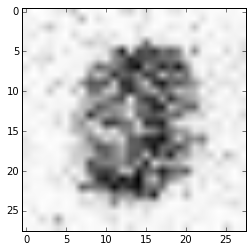

In [14]:
print(r.weights.shape)
plt.imshow(sample[11][1:].reshape(28,28), cmap = 'Greys')
plt.show()
#print(sample[11][1:].reshape(28,28))

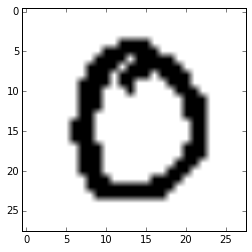

In [15]:
plt.imshow(data_array[11].reshape(28,28), cmap = 'Greys')
plt.show()